In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import norm
from scipy import stats

import xgboost as xgb
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv("../../../mltestdata/03_predict_hourly_wage/Income_training.csv")
test = pd.read_csv("../../../mltestdata/03_predict_hourly_wage/Income_testing.csv")

# Data Exploring

In [3]:
train.head()

compositeHourlyWages  age  yearsEducation  sex1M0F
0                 21.38   58              10        1
1                 25.15   42              16        1
2                  8.57   31              12        0
3                 12.07   43              13        0
4                 10.97   46              12        0

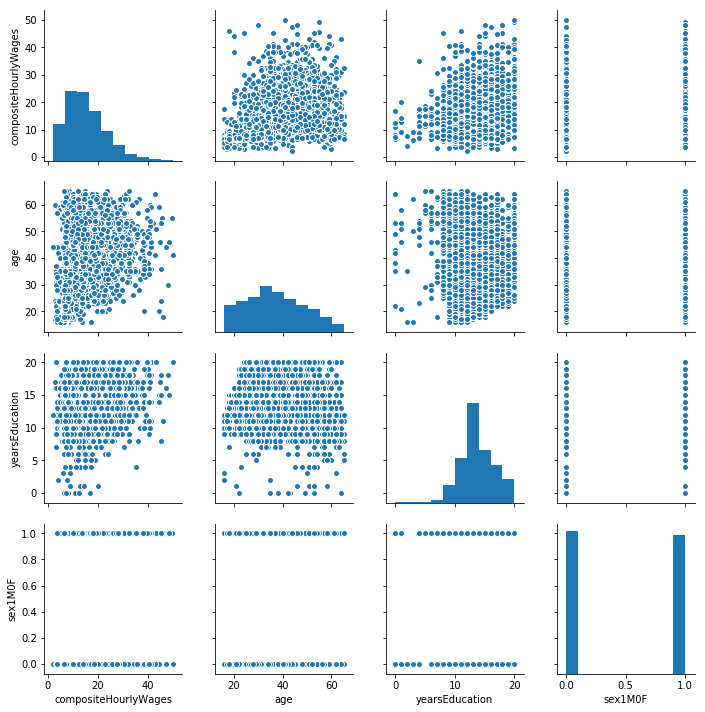

In [4]:
sns.pairplot(train)

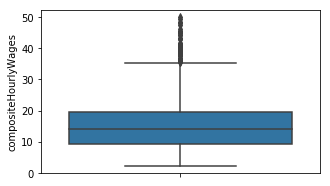

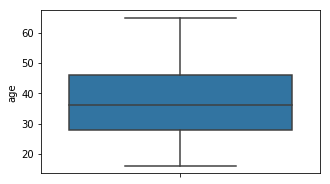

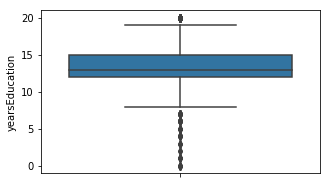

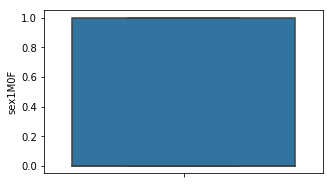

In [6]:
for column in train.columns:
    fig = plt.figure(figsize=(5,3))
    ax = sns.boxplot(y=column, data=train)

# Preprocessiong
* * * *

* * *

In [7]:
train_target = train.compositeHourlyWages.values

test_ID = test['ID']
test.drop("ID", axis = 1, inplace = True)

train.drop(['compositeHourlyWages'], axis=1, inplace=True)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(train,train_target,test_size=0.2,random_state=0)

# Modeling
* * * * *

## XGBoost

### 1. Validation with local train

In [9]:
# xgboostモデルの作成
#ind_params = {'objective': 'reg:linear'}

#reg = xgb.XGBRegressor(**ind_params)
reg = xgb.XGBRegressor()
reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [10]:
y_train_predict = reg.predict(X_train)
y_pred = reg.predict(X_test)

In [11]:
# The error metric: RMSE
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

print("RMSE from local train: ", rmse(y_test, y_pred))
print("MSE from local train: ", mean_squared_error(y_test, y_pred))
print("R2 from local train: ", r2_score(y_test, y_pred))

RMSE from local train:  6.02475299555
MSE from local train:  36.2976486573
R2 from local train:  0.395235324935


### 2. Validation with GridSearch

In [12]:
from sklearn.model_selection import GridSearchCV

In [15]:
# XGBoost params
xgb_params = {
    'objective' : ['reg:gamma','reg:linear'],
    'learning_rate' : [0.05,0.75,0.1,0.125],
    'n_estimators' : [50,100,200],
    'max_depth' : [2,4,6],
    'subsample' : [0.79,0.8,0.81,0.85],
    'colsample_bytree' : [0.9,1.0],
    'min_child_weight' : [13,14, 15, 16]
}

In [16]:
#scoring_func = make_scorer(mean_squared_error)

#grid = GridSearchCV(reg,xgb_params,scoring=scoring_func,cv=5,n_jobs=-1)
grid = GridSearchCV(reg,xgb_params,scoring='neg_mean_squared_error',cv=5,n_jobs=-1)

grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'objective': ['reg:gamma', 'reg:linear'], 'learning_rate': [0.05, 0.75, 0.1, 0.125], 'n_estimators': [50, 100, 200], 'max_depth': [2, 4, 6], 'subsample': [0.79, 0.8, 0.81, 0.85], 'colsample_bytree': [0.9, 1.0], 'min_child_weight': [13, 14, 15, 16]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [17]:
# Best Params and Score
print("Best params: ", grid.best_params_)
print("Best Estimator: ", grid.best_estimator_)

print("MSE: ", grid.best_score_)

# best_score_ : Mean cross-validated score of the best_estimator

Best params:  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 14, 'n_estimators': 100, 'objective': 'reg:gamma', 'subsample': 0.8}
Best Estimator:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=14, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:gamma', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)
MSE:  -38.7922204065


In [18]:
# The result of combination
index = 1
for params, mean_score, scores in grid.grid_scores_:
    print("%d) %0.3f (+/-%0.03f) " % (index, mean_score, scores.std() / 2))
    print("Params: %r" % params)
    print("_"*30)
    index = index + 1

/Users/suzukiry/lab/March/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


1) -182.148 (+/-4.759) 
Params: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 13, 'n_estimators': 50, 'objective': 'reg:gamma', 'subsample': 0.79}
______________________________
2) -182.139 (+/-4.756) 
Params: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 13, 'n_estimators': 50, 'objective': 'reg:gamma', 'subsample': 0.8}
______________________________
3) -182.139 (+/-4.755) 
Params: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 13, 'n_estimators': 50, 'objective': 'reg:gamma', 'subsample': 0.81}
______________________________
4) -182.134 (+/-4.754) 
Params: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 13, 'n_estimators': 50, 'objective': 'reg:gamma', 'subsample': 0.85}
______________________________
5) -41.799 (+/-1.707) 
Params: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 13, 'n_estimators

In [19]:
# 改めて最適パラメータで学習
gdm = xgb.XGBRegressor(**grid.best_params_) # 6.01679534923
#gdm = xgb.XGBRegressor(**xgb_params) # 6.0907929398
gdm.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=14, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:gamma', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [20]:
y_pred_gs = gdm.predict(X_test)

In [21]:
# The error metric: RMSE
print("RMSE from local train: ", rmse(y_test, y_pred_gs))
print("MSE from local train: ", mean_squared_error(y_test, y_pred_gs))
print("R2 from local train: ", r2_score(y_test, y_pred_gs))

RMSE from local train:  5.99283617268
MSE from local train:  35.9140853925
R2 from local train:  0.401625973415


In [22]:
predictions_gdm = gdm.predict(test)

# Submission

In [22]:
sub = pd.DataFrame()
sub['ID'] = test_ID
sub['compositeHourlyWages'] = predictions_gdm
sub.to_csv('rs_hourly_submission_29Dec17_rs_predict_hourly_wage_v06_xgb-feature_engineering.ipynb.csv',index=False)

* * * *

Public LB: 6.30619